# Simulation de l'algorithme UCB1
Chaque algorithme sera implementer suivant une approche object

In [47]:
import numpy as np

class UCB1 :
    """we create a new type of object called UCB1 with 
    Attributes:
    _ _ _ _ _ _  
    n_arms:int the number of arms"""
    def __init__(self, n_arms):
        self.n_arms = n_arms  # numbers of arms
        self.counts = np.zeros(n_arms) # for any arms we store  the number of time that it was played in this numpy table initialize by full zeros
        self.values = np.zeros(n_arms) # we also done that for store the average for all arms
        self.total_counts = 0 # for store the moment t step by step

    def select_arm(self):

        """This methode return the maximum value of the upper bound cumullative"""
        if self.total_counts < self.n_arms:
            #chaque bras est joué une fois: c'est le tir initial
            return self.total_counts
        else:
            UCB1_values = self.values + np.sqrt(2 * np.log(self.total_counts) / self.counts)
            return np.argmax(UCB1_values)    

    def update(self, chosen_arm, reward):
        """ this methode is used to update our algorithm it is an recursive methode
        intput:
                - chosen_arm : is the arm considered as chosen
                - reward is the reward ontained through the choise  of the  arm called chosen_arm  """

        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n-1)/n)*value + (1/n)*reward #  il s'agit de la mise a jour de la moyenne empirique
        self.values[chosen_arm] = new_value

## Implementation

Nous souhaitons maintenant implémenter l’algorithme UCB1 et générer des graphes de regret, en considérant des récompenses de type Bernoulli. Pour cela, nous considérons le cas de K=2 bras, c’est-à-dire deux sources de récompenses aléatoires :

Le premier bras génère des observations issues d’une variable aléatoire 𝑋∼Bernoulli(1/3), Le second bras génère des observations(recompenses) issues d’une variable aléatoire Y∼Bernoulli(1/4) les recompenses pour chaque bras sont donc alors indépendantes et identiquement distribuées

In [48]:
import matplotlib.pyplot as plt

def reward_chosen_arm(arm):
    return np.random.binomial(1, means_arms[arm] )

#parameters
n_plays = 20000
n_sim = 100
means_arms = [ 1/3, 1/4 ]   

#matrice pour stoquer les regrets
regrets_mat  = []

#simulation
for sim in range( n_sim  ):
    algo_UCB1 = UCB1(n_arms= 2)
    cumulative_reward = 0
    regrets = []
    for t in range( 1 , n_plays + 1):
        arm = algo_UCB1.select_arm()
        reward = reward_chosen_arm(arm)
        cumulative_reward += reward 
        algo_UCB1.update(arm, reward)
        regret = t * max(means_arms) - np.sum([algo_UCB1.counts[i]*means_arms[i] for i in range(algo_UCB1.n_arms)])
        regrets.append( regret)
    
    regrets_mat.append(regrets)

# muyenne des regrets sur toutes simulations
regrets_plot = np.mean(regrets_mat, axis = 0)

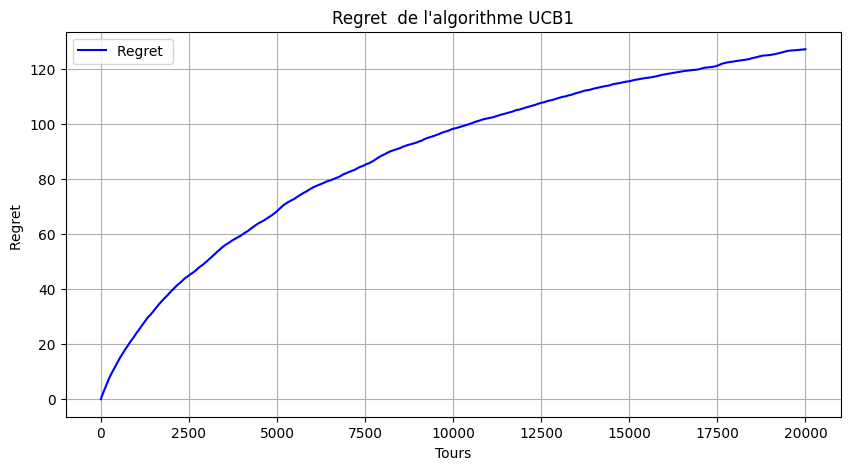

In [49]:
# Affichage : courbes de regret
plt.figure(figsize=(10,5))
plt.plot(regrets_plot, label="Regret ", color='blue')

plt.xlabel("Tours")
plt.legend()
plt.ylabel("Regret ")
plt.title("Regret  de l'algorithme UCB1")
plt.grid(True)
plt.show()

 On définit le regret cumulé après t  tours  comme :
    $
    R(t) = t\mu^* - \sum_{i=1}^K \mu_i\mathbb{E}[T_{i}(t)]
    $
    où $ \mu^* = \max_{i=1,\dots,K} \mu_i $ est la récompense moyenne maximale et $ T_{i}(t) $ est le nombre de fois que  le bras i a éte choisit parmis les $ t $ tours ainsi jusqu'a n.

Il mesure ce qu’on a perdu en ne jouant pas toujours le meilleur bras.

La courbe est croissante, concave  et de plus en plus plate, ce qui prouve bien que l'algorithme apprend a choisir le meilleur bras avec un regret logarithmique

# UCB-type Algorithm phi-mixing bandits

## Simulations: iid setting Bras bernoulli

On teste une implementation sur 2 bras les mêmes que lors de l'implementation de l'algorithme UCB1 et pour le moment on considère que tous les bras ont des  recompenses indépendantes et identiquement distribuées 

In [50]:

class PhiMixingUCB:
    def __init__(self, k, phi_sum, T):
        self.k = k                      # number of arms
        self.phi_sum = phi_sum         # ‖phi‖ = sum of φ-mixing coefficients
        self.T = T                      # total time steps
        self.X = np.zeros(k)           # empirical means
        self.s = np.ones(k, dtype=int) # number of times each arm has been selected
        self.arm_counts = np.ones(k)   # total counts per arm

    def run(self, arms):
        t = 0
        rewards = []

        # Initial play: one pull per arm
        for i in range(self.k):
            reward = arms[i]()
            self.X[i] = reward
            rewards.append(reward)
            t += 1

        # Main loop
        while t < self.T:
            # Compute UCB for each arm
            ucb_values = self.X + np.sqrt(8 * (1 + 8 * self.phi_sum) * (0.125 + np.log(t + 1)) / (2 * self.s)) \
                         + (self.phi_sum / (2 * self.s - 1))
            j = np.argmax(ucb_values)

            # Play arm j for 2^s_j consecutive steps
            batch_size = 2 ** self.s[j]
            actual_batch = min(batch_size, self.T - t)
            rewards_batch = [arms[j]() for _ in range(actual_batch)]
            mean_reward = np.mean(rewards_batch)

            # Update statistics
            self.X[j] = mean_reward
            self.s[j] += 1
            self.arm_counts[j] += actual_batch
            rewards.extend(rewards_batch)
            t += actual_batch

        return np.array(rewards)







In [51]:
# Simulation: Bernoulli arms + regret plot


# Bernoulli arms with parameters 0.3 and 0.5
arm_probs = [0.3, 0.5]
best_mean = max(arm_probs)
arms = [lambda p=p: np.random.binomial(1, p) for p in arm_probs]

# Parameters
T = 20000
n_sim = 100
phi_sum = 0.9  # sum of φ-mixing coefficients

# matrix for store the regret for each similation
regret_mat = []

# Run algorithm for n_sim similation
for sim in range(n_sim):
    ucb_agent = PhiMixingUCB(k=2, phi_sum=phi_sum, T=T)
    rewards = ucb_agent.run(arms)

    # Compute regret
    cumulative_rewards = np.cumsum(rewards)
    optimal_cumulative = np.arange(1, T + 1) * best_mean
    regret = optimal_cumulative - cumulative_rewards
    regret_mat.append(regret)
regret_plt = np.mean(regret_mat, axis = 0)



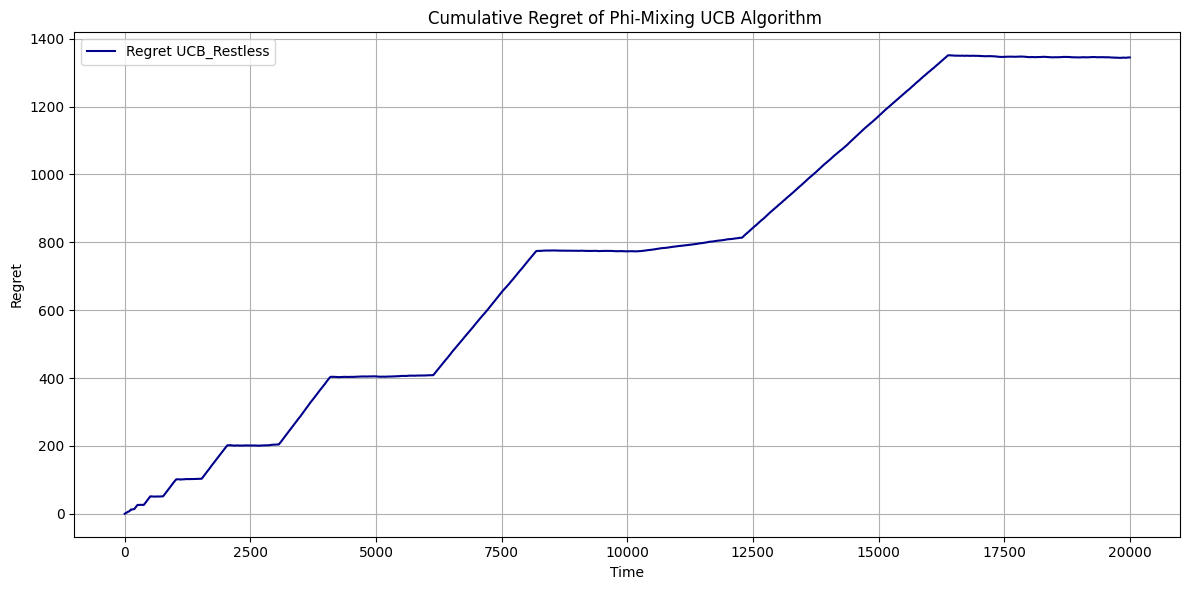

In [52]:
# Plot regret
plt.figure(figsize=(12, 6))
plt.plot(regret_plt, label='Regret UCB_Restless', color='darkblue')
plt.title("Cumulative Regret of Phi-Mixing UCB Algorithm ")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

- La courbe est croissante et de plus en plus plate ce qui prouve que l'algorithme apprend a se renforcer au fil du temps,
- La courbe est croissante, positive et quasi concave
- La tendance en escalier est du au fait que un bras est jouer consécutivement et est mise a jour consécutivement $2^s$ fois ou $s$ est le nombre de fois que le bras est jouer 


## UCB 1 VS UCB Restless : iid setting

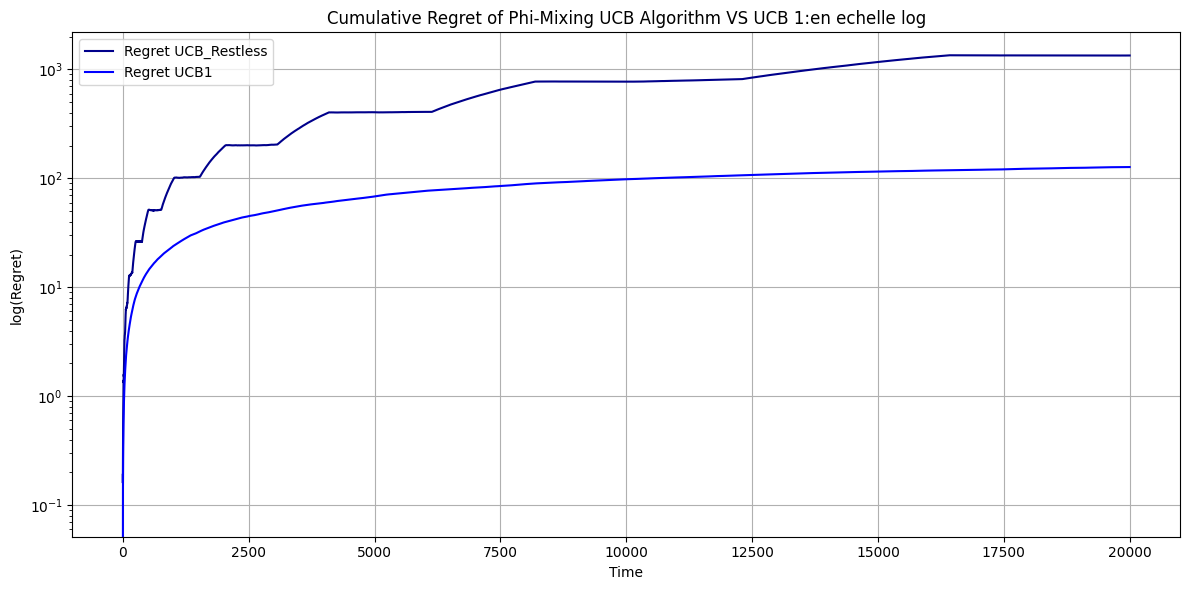

In [53]:
# Plot regret
plt.figure(figsize=(12, 6))
plt.plot(regret_plt, label='Regret UCB_Restless', color='darkblue')
plt.plot(regrets_plot,label = "Regret UCB1 ", color = "blue")
plt.title("Cumulative Regret of Phi-Mixing UCB Algorithm VS UCB 1:en echelle log")
plt.yscale("log")
plt.xlabel("Time")
plt.ylabel("log(Regret)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Le cadre classique de l'algorithme UCB1 est le cadre ou les recompenses des bras sont iid, ce qui n'est pas le cas pour l'algorithme UCB en mode restless c'est pourquoi d'après ce graphique l'algorithme UCB1 est meilleur dans le cadre iid.

La question qu'on se pose est de savoir quel est l'impact de ces deux algorithmes dans le cadre ou un des bras génère des recompenses qui sont dépendantes les unes des autres

## Simulation: Marchov chains setting 

### Description de la simulation

Ici, on simule un problème à deux bras :

- **Bras 1** : une loi de Bernoulli i.i.d. de paramètre 0.3.
- **Bras 2** : génère des récompenses issues d'une chaîne de Markov à 2 états, avec un espace d'états \( E = \{0, 1\} \).

La matrice de transition de cette chaîne est donnée par :

\[
P = \begin{bmatrix}
1 - \epsilon & \epsilon \\
\epsilon & 1 - \epsilon
\end{bmatrix}
\]

On fait varier \(\epsilon\) parmi les valeurs \([0.5, 0.6, 0.7, 0.8, 0.9, 0.95]\).



### Remarques théoriques

La moyenne stationnaire du bras 2 est théoriquement égale à 0.5, quelle que soit la valeur de \(\epsilon\).



### Objectif

L'intérêt d'utiliser un bras avec des récompenses markoviennes est de sortir du cadre classique des algorithmes de bandits, qui supposent généralement des récompenses i.i.d.

Cela permet d'étudier la robustesse des algorithmes dans un contexte où les bras ne suivent pas forcément des distributions indépendantes.

La chaîne de Markov est un exemple typique de dépendance : la récompense à l'étape \(t\) dépend uniquement de l'état à l'étape \(t-1\), ce qui introduit une corrélation temporelle dans les observations.

In [57]:


# Chaine de Markov binaire
class MarkovArm:
    def __init__(self, transition_matrix, initial_state=0):
        self.P = transition_matrix
        self.state = initial_state

    def __call__(self):
        current_state = self.state
        # similation of the next transition
        self.state = np.random.choice([0, 1], p = self.P[current_state])
        return current_state

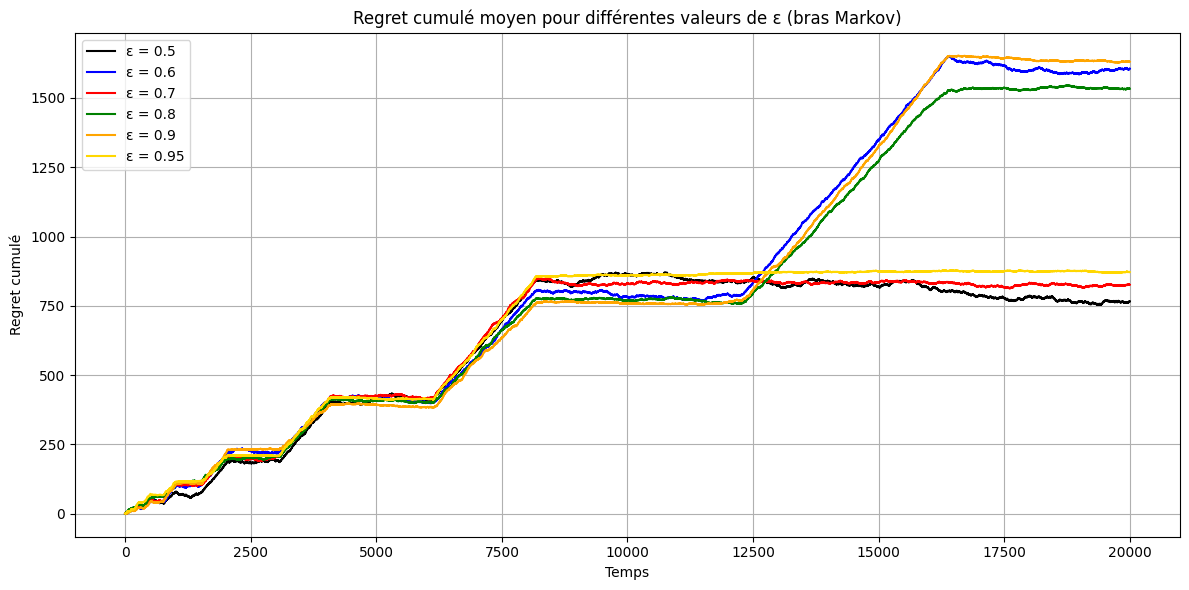

In [94]:
# Paramètres
following_eps = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
colors = ["black", "blue", "red", "green", "orange", "gold"]
k = 2
T = 20000
n_sim = 1
norm_phi = 0.9
arm_probs = [0.3, 0.5]
best_mean = max(arm_probs)

plt.figure(figsize=(12, 6))

for idx, eps in enumerate(following_eps):
    transition_matrix = [[ 1-eps, eps],
                         [eps, 1- eps]]

    # Deux bras : un bras Bernoulli, un bras Markov
    regrets_mat = []
    for sim in range(n_sim):
        arms = [
            lambda p=arm_probs[0]: np.random.binomial(1, p),
            MarkovArm(transition_matrix, initial_state=0)
        ]

        ucb_agent2 = PhiMixingUCB(k=k, phi_sum=norm_phi, T=T)
        rewards = ucb_agent2.run(arms)

        cumulative_rewards = np.cumsum(rewards)
        optimal_cumulative = np.arange(1, T + 1) * best_mean
        regret = optimal_cumulative - cumulative_rewards
        regrets_mat.append(regret)

    # Moyenne des regrets sur les simulations
    regret_plt2 = np.mean(regrets_mat, axis=0)
    plt.plot(regret_plt2, label=f"ε = {eps}", color=colors[idx])

plt.title("Regret cumulé moyen pour différentes valeurs de ε (bras Markov)")
plt.xlabel("Temps")

plt.ylabel("Regret cumulé")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



D'après la formulation de la matrice de transition, plus epsilon est petit plus la proba de rester a l’état stationnaire  est grande et donc plus le regret est grand ce qui fait en sorte que plus epsilon grand plus le regret est moins, mais en pratique cette remarque n'est pas facilement observable compte tenu de la faible dépendance en terme de moyenne stationnaire de la chaîne de Markov

## UCB 1 VS UCB Retless : non iid setting

On veut maintenant naviguer dans le cadre non iid ie le cas ou un des bras est markovien par exemple, et on veut savoir dans ce cas quel des deux algorithmes est performant

In [101]:
eps1 = 0.9
eps = 0.75
transition_matrix1 = [[ 1-eps1, eps1],
                         [eps1, 1- eps1]]
transition_matrix = [[ 1-eps, eps],
                         [eps, 1- eps]]

markov_reward1 = MarkovArm( transition_matrix= transition_matrix1)
markov_reward2 = MarkovArm( transition_matrix= transition_matrix)





def reward_chosen_arm(arm):
    if arm == 0 :
        return   np.random.binomial(1, means_arms[arm] ) 
    else :
        return   markov_reward1.__call__() 
    

#parameters
n_plays = 20000
n_sim = 5
means_arms = [ 0.3, 0.5 ]  

#matrice pour stoquer les regrets
regrets_matucb1  = []

#simulation
for sim in range( n_sim  ):
    algo_UCB1 = UCB1(n_arms= 2)
    regretsucb1 = []
    for t in range( 1 , n_plays + 1):
        arm = algo_UCB1.select_arm()
        reward = reward_chosen_arm(arm)
        algo_UCB1.update(arm, reward)
        regretucb1 = t * max(means_arms) - np.sum([algo_UCB1.counts[i]*means_arms[i] for i in range(algo_UCB1.n_arms)])
        regretsucb1.append( regretucb1)
    
    regrets_matucb1.append(regretsucb1)

# muyenne des regrets sur toutes simulations
regrets_plot_ucb1 = np.mean(regrets_matucb1, axis = 0)

In [102]:
arm_probs = [0.3, 0.5]
best_mean = max(arm_probs)
arms = [lambda p=arm_probs[0]: np.random.binomial(1, p), MarkovArm(transition_matrix1)]

# Parameters
T = 20000
n_sim = 5
phi_sum = 0.9  # sum of φ-mixing coefficients

# matrix for store the regret for each similation
regret_mat = []

# Run algorithm for n_sim similation
for sim in range(n_sim):
    ucb_agent = PhiMixingUCB(k=2, phi_sum=phi_sum, T=T)
    rewards = ucb_agent.run(arms)

    # Compute regret
    cumulative_rewards = np.cumsum(rewards)
    optimal_cumulative = np.arange(1, T + 1) * best_mean
    regret = optimal_cumulative - cumulative_rewards
    regret_mat.append(regret)
regret_plt = np.mean(regret_mat, axis = 0)

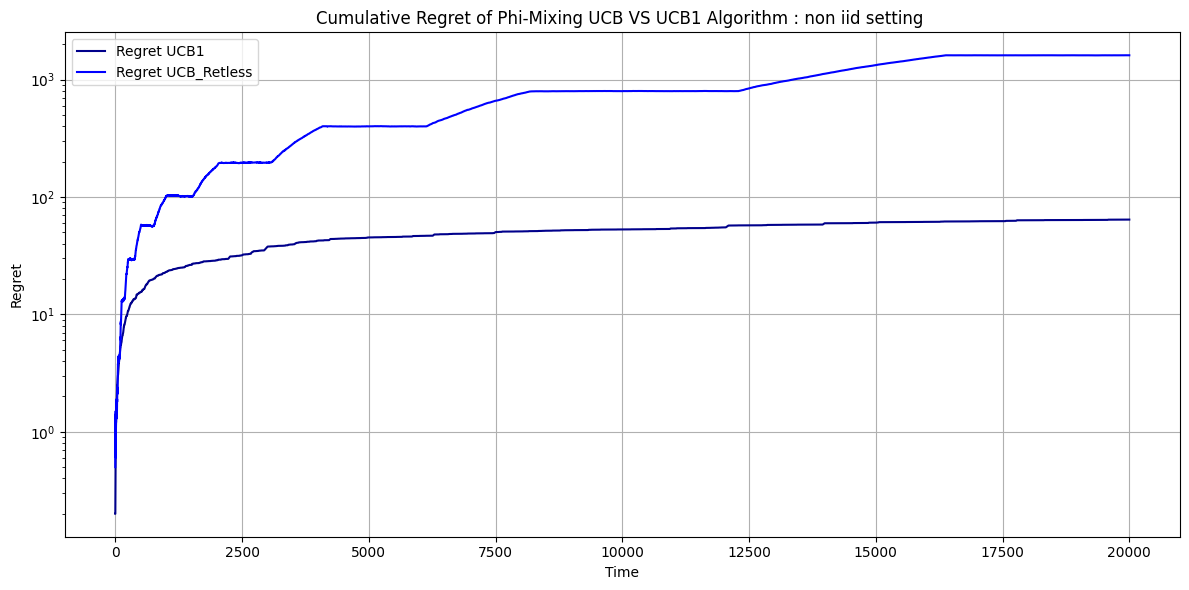

In [104]:
# Plot regret
plt.figure(figsize=(12, 6))
plt.plot(regrets_plot_ucb1, label='Regret UCB1', color='darkblue')
plt.plot(regret_plt, label='Regret UCB_Retless', color='blue')
plt.title("Cumulative Regret of Phi-Mixing UCB VS UCB1 Algorithm : non iid setting ")
plt.yscale("log")
plt.xlabel("Time")
plt.ylabel("Regret")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()